# Implementação 2: Toy Example

Esse notebook apresenta a segunda implementação do Toy Example proposto.
Sua proposta segue os seguintes objetivos:
* Além do modelo implementado antes, ele também conterá métricas e avaliações quanto ao seu desempenho de justiça.
* Assim como o notebook anterior, o seu objetivo é dar prosseguimento ao checklist proposto pelo NIAR.

## Processamento dos dados

As informações quanto ao pré-processamento podem ser encontradas no notebook anterior. Agora, há também um data card descrevendo as propriedades do dataset usado no modelo.

Para essa versão, devido à necessidade de uma análise de justiça do modelo, ficou aparente a necessidade de revisitar algumas características do dataset que foram mal representadas. Para tal, novos atributos foram criados:
* sex_f_share (Razão de presença de mulheres);
* age_15_59_share e age_0_14_share (Razão da presença de diferentes faixas etárias, note que 60 para mais já estava presente no dataset);
* raca_branca_share, raca_negra_share e raca_outras_share (Razão de presença das diferenças raças presentes no dataset);
* O estado (region) onde o hospital está presente (para avaliação de desempenho do modelo por região).

## Documentação

Para essa versão, além do model card e do data card, será feito relatórios sobre a performance do modelo dentro das dimensões da IAR.

* model_card.pdf: Documentação que sumariza os detalhes, desempenho e observações sobre o modelo.
* data_card.md: Documentação completa sobre o dataset usado, com suas propriedades e processamento.
* fairness_report.md: Relatório dos passos tomados para verificar e amenizar viéses presentes no modelo.
* ...
* ...

### Etapa 0: Recriação dos Modelos Anteriores

A fim de verificar o desempenho com métricas visando a justiça do modelo, recria-se o modelo usado anteriormente.

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import mean_absolute_error, mean_squared_error


df = pd.read_csv("./SIH_Dados/Tabela_lag_Final.csv")
df.dropna(inplace=True)

X_Train = df[(df.year >= 2022) & (df.year <= 2024)]
X_Train = X_Train[(X_Train.year < 2024) | (X_Train.month <= 6)].reset_index(drop=True)
Y_Train = X_Train["J_count"]

X_Valid = df[(df.year == 2024) & (df.month >= 7)].reset_index(drop=True)
Y_Valid = X_Valid["J_count"]

X_Test = df[df.year == 2025].reset_index(drop=True)
Y_Test = X_Test["J_count"]

# Salvando para mais tarde
df_resultados = X_Test[["year", "month", "CNES", "hospital_porte", "region"]]


X_Train.drop(columns=["region", "CNES", "J_count"], inplace=True)
X_Valid.drop(columns=["region", "CNES", "J_count"], inplace=True)
X_Test.drop(columns=["region", "CNES", "J_count"], inplace=True)


In [2]:
model = sk.linear_model.LinearRegression().fit(X_Train, Y_Train)

val_resul = model.predict(X_Valid)
test_resul = model.predict(X_Test)

In [3]:
seed = 778

lgb_train = lgb.Dataset(X_Train, Y_Train)
lgb_valid = lgb.Dataset(X_Valid, Y_Valid)


model = lgb.train(params={"objective": "poisson"}, train_set=lgb_train, valid_sets=lgb_valid, callbacks=[lgb.early_stopping(stopping_rounds=5)])

res_pred = model.predict(X_Test, num_iteration=model.best_iteration)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24165
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 104
[LightGBM] [Info] Start training from score 3.504180
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's poisson: -90.9812


### Etapa 1: Avaliação de Justiça Inicial

Verifica-se se há disparidade de desempenho para diferentes grupos sociais. Como os valores são agregados, para fazer essa verificação, é necessário categorizar cada linha com qual grupo é mais representado. Por exemplo, se há mais mulheres que homens, então aquela linha será categorizada como "Fem" quanto a sexo.

Além disso, os valores estão em três "lags" diferentes. Assim, para determinar em quais casos o grupo é maioria, fazemos uma média dos três valores (exceto regiões, que apenas verifica a quantidade de amostras totais há com ela).

Quanto as métricas usadas, será usado o SMAPE (Symmetric mean absolute percentage error) para observar as diferenças. Não foi usado MAE e RMSE pois ambos trabalham com valores absolutos, assim dados com baixa amostra resultaram em valores menores, mesmo possuindo uma taxa de erro maior.

In [4]:
def categ_idade(linha):
    mean_60p = ((linha["J_age_60p_share_lag1"] + linha["J_age_60p_share_lag3"] + linha["J_age_60p_share_lag12"]) / 3)
    mean_15_59 = ((linha["J_age_15_59_share_lag1"] + linha["J_age_15_59_share_lag3"] + linha["J_age_15_59_share_lag12"]) / 3)
    mean_0_14 = ((linha["J_age_0_14_share_lag1"] + linha["J_age_0_14_share_lag3"] + linha["J_age_0_14_share_lag12"]) / 3)
    if mean_60p > mean_0_14 and mean_60p > mean_15_59:
        return "60+"
    if mean_15_59 > mean_0_14:
        return "15-59"
    return "0-14"


def categ_sexo(linha):
    if (linha["J_sex_m_share_lag1"] + linha["J_sex_m_share_lag3"] + linha["J_sex_m_share_lag12"]) / 3 > (linha["J_sex_f_share_lag1"] + linha["J_sex_f_share_lag3"] + linha["J_sex_f_share_lag12"]) / 3:
        return "Mas"
    return "Fem"


def categ_raca(linha):
    mean_branca = ((linha["J_raca_branca_share_lag1"] + linha["J_raca_branca_share_lag3"] + linha["J_raca_branca_share_lag12"]) / 3)
    mean_preta = ((linha["J_raca_preta_share_lag1"] + linha["J_raca_preta_share_lag3"] + linha["J_raca_preta_share_lag12"]) / 3)
    mean_outras = ((linha["J_raca_outras_share_lag1"] + linha["J_raca_outras_share_lag3"] + linha["J_raca_outras_share_lag12"]) / 3)
    if mean_branca > mean_preta and mean_branca > mean_outras:
        return "Branca"
    if mean_preta > mean_outras:
        return "Preta"
    return "Outra"

In [5]:
df_resultados["categoria_idade"] = X_Test.apply(categ_idade, axis=1)
df_resultados["categoria_sexo"] = X_Test.apply(categ_sexo, axis=1)
df_resultados["categoria_raca"] = X_Test.apply(categ_raca, axis=1)

df_resultados["Valor Real"] = Y_Test
df_resultados["Base resultados"] = test_resul
df_resultados["LightGBM resultados"] = res_pred

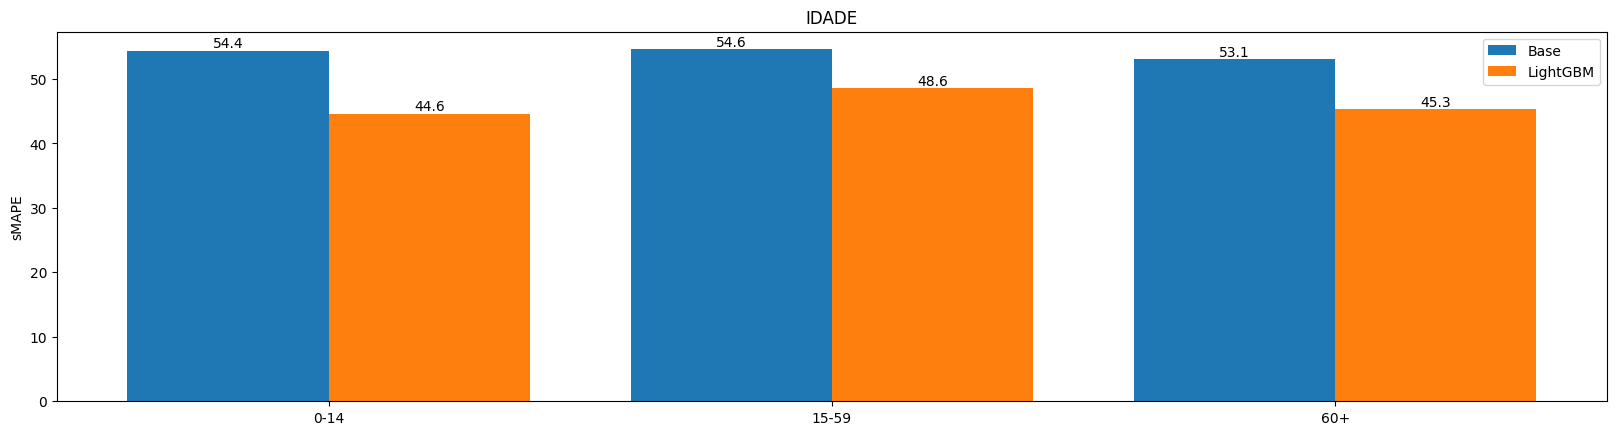

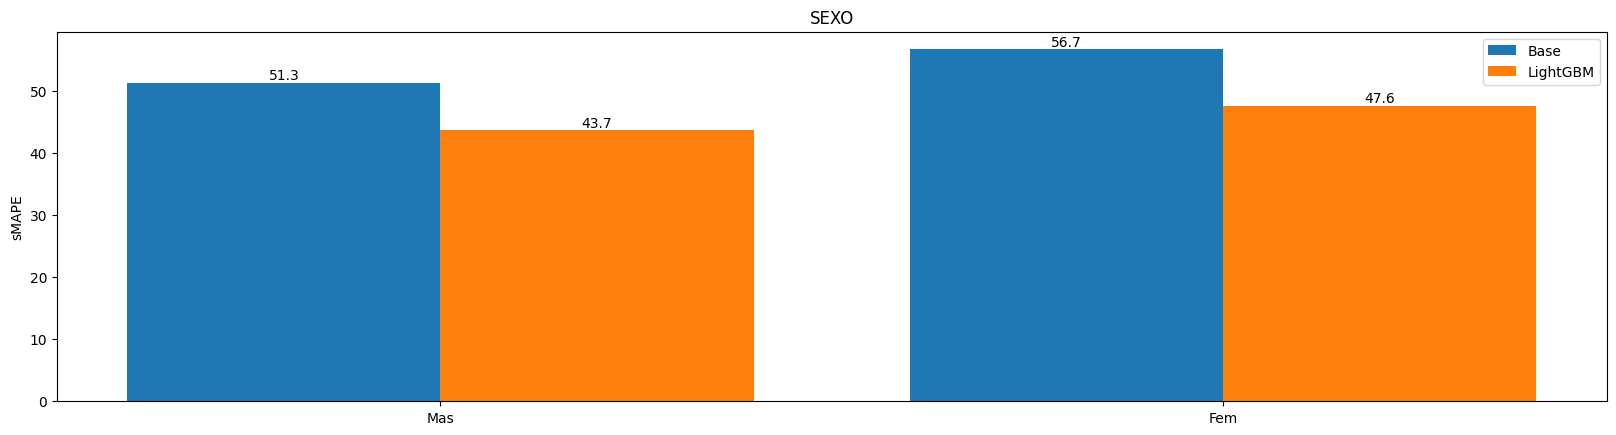

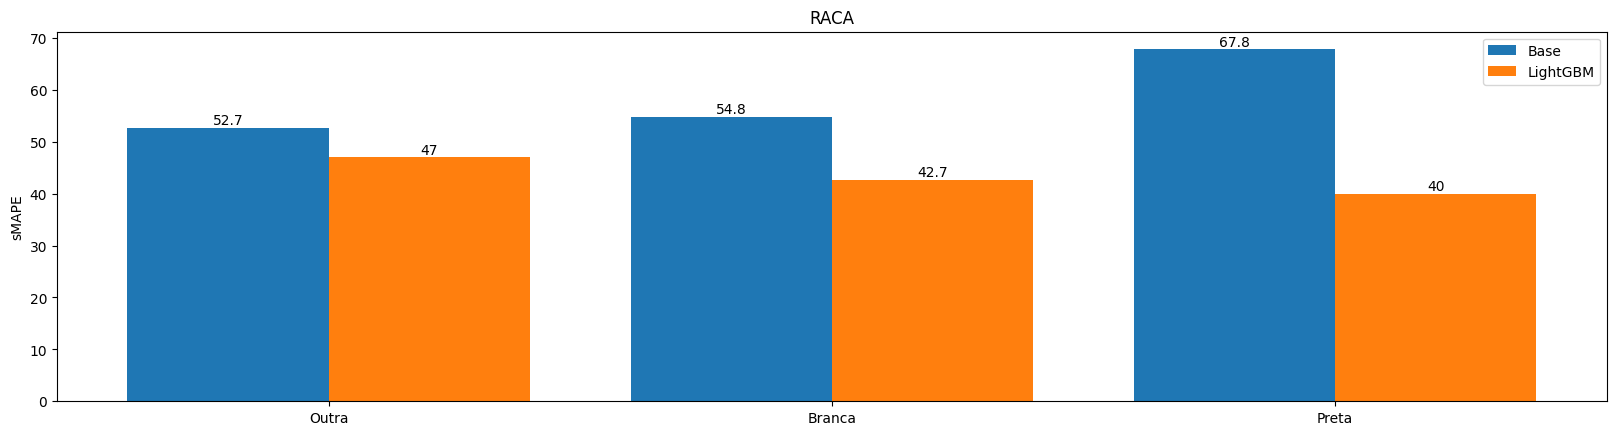

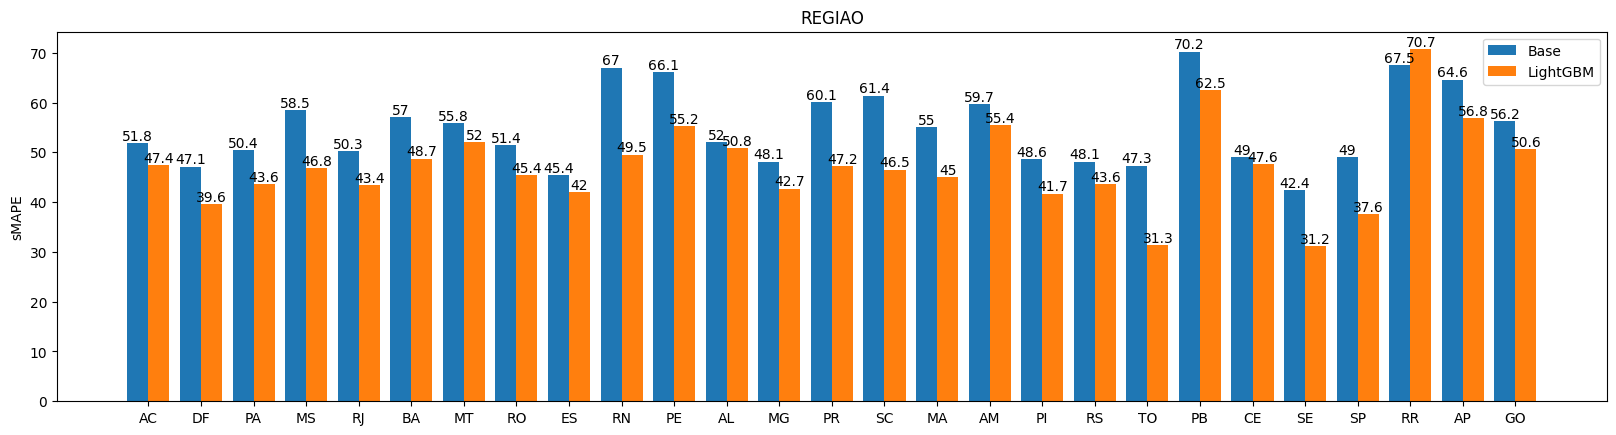

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def res_cabecalho(titulo):
    print("\n\n=============================\t   ", titulo, " \t=============================")
    print("\t\t\t|\t\t\t\t|")
    print("   Metrica\t\t|   Base\t\t\t|   LightGBM")
    print("\t\t\t|\t\t\t\t|")

def res_linha(metrica, valor_base, valor_lgb):
    print(metrica, "\t\t\t|", valor_base, "\t\t|", valor_lgb)
    print("\t\t\t|\t\t\t\t|")

def res_quebra(grupo):
    print("------------------------+---------  ", grupo, "\t--------+--------------------")
    print("\t\t\t|\t\t\t\t|")

def plot_vies(df, titulo, categoria):
    res_cabecalho(titulo)
    chaves = df[categoria].unique()
    for chave in chaves:
        df_temp = df[df[categoria] == chave]
        smape_base = smape(df_temp["Valor Real"], df_temp["Base resultados"])
        smape_lgb = smape(df_temp["Valor Real"], df_temp["LightGBM resultados"])
        res_quebra(chave)
        res_linha("SMAPE", smape_base, smape_lgb)
        
def verificar_vies(df, titulo, categoria):
    chaves = df[categoria].unique()
    valores_base = []
    valores_lgb = []
    for chave in chaves:
        df_temp = df[df[categoria] == chave]
        valores_base.append(round(smape(df_temp["Valor Real"], df_temp["Base resultados"]), 1))
        valores_lgb.append(round(smape(df_temp["Valor Real"], df_temp["LightGBM resultados"]), 1))

    fig = plt.figure()
    fig.set_figwidth(20)
    
    w, x = 0.4, np.arange(len(chaves))
    bars1 = plt.bar(x - w/2, valores_base, w, label="Base")
    bars2 = plt.bar(x + w/2, valores_lgb, w, label="LightGBM")
    plt.bar_label(bars1)
    plt.bar_label(bars2)
    plt.xticks(x, chaves)
    plt.ylabel("sMAPE")
    plt.title(titulo)
    plt.legend()
    plt.show()
    

verificar_vies(df_resultados, "IDADE", "categoria_idade")
verificar_vies(df_resultados, "SEXO", "categoria_sexo")
verificar_vies(df_resultados, "RACA", "categoria_raca")
verificar_vies(df_resultados, "REGIAO", "region")

A métrica SMAPE verifica em até quantos porcento o modelo erra (por exemplo, erramos em GO até 50% do valor correto, pelo modelo LightGBM). Isso significa que valores maiores representam performance pior do modelo, indicando uma taxa de erro maior.

Como houve um melhor desempenho pelo modelo LightGBM, todas as referências a resultados obtido de agora em diante sempre referenciarão valores obtidos por esse modelo.



#### Primeira análise

Observa-se que, quanto às categorias de idade, sexo e raça, os resultados não possuem disparidade excessivas, possuindo uma diferença de até 7% (a maior diferença está na comparação entre pessoas pretas e de outras raças, 7%).

No entanto, esse estudo revela uma grande diferença de performance entre os estados. A maioria permanece na casa dos 40% e 50%, porém o pior caso chega ao 70% (RR) e o melhor ao 31% (SE e TO).

### Etapa 2: Mitigação de viés
Para reduzir o viés apresentado, será implementado reamostragem, uma estratégia que visa igualar o número de amostras entre diferentes grupos. Essa estratégia é usada principalmente para modelos de classificação, porém pode ser útil para outros tipos de modelo também.

Para tal, primeiro verifica-se quantas amostras há para cada grupo.

Note que a reamostragem (criação de dados sintéticos) é feita apenas nos dados de treinamento.

In [7]:
X_Train = df[(df.year >= 2022) & (df.year <= 2024)]
X_Train = X_Train[(X_Train.year < 2024) | (X_Train.month <= 6)].reset_index(drop=True)


X_Valid = df[(df.year == 2024) & (df.month >= 7)].reset_index(drop=True)
Y_Valid = X_Valid["J_count"]

X_Test = df[df.year == 2025].reset_index(drop=True)
Y_Test = X_Test["J_count"]


In [8]:
def ver_cabecalho(grupo):
    print("\n\t", grupo.upper())
    print("--------+---------------------")
    print("grupo\t|\t Total")
    print("--------+---------------------")

def ver_linha(chave, valor):
    print(chave, "\t|\t", valor)


def verificar_idade(df):
    mean_60p = ((df["J_age_60p_share_lag1"] + df["J_age_60p_share_lag3"] + df["J_age_60p_share_lag12"]) / 3)
    mean_15_59 = ((df["J_age_15_59_share_lag1"] + df["J_age_15_59_share_lag3"] + df["J_age_15_59_share_lag12"]) / 3)
    mean_0_14 = ((df["J_age_0_14_share_lag1"] + df["J_age_0_14_share_lag3"] + df["J_age_0_14_share_lag12"]) / 3)

    tot_60p = 0
    tot_15_59 = 0
    tot_0_14 = 0
    for i in range (0, len(mean_60p)):
        if mean_60p[i] > mean_15_59[i] and mean_60p[i] > mean_0_14[i]:
            tot_60p += 1
        elif mean_15_59[i] >= mean_0_14[i]:
            tot_15_59 += 1
        else: tot_0_14 += 1

    ver_cabecalho("Idade")
    ver_linha("60+", tot_60p)
    ver_linha("15-59", tot_15_59)
    ver_linha("0-14", tot_0_14)


def verificar_sexo(df):
    mean_m = ((df["J_sex_m_share_lag1"] + df["J_sex_m_share_lag3"] + df["J_sex_m_share_lag12"]) / 3)
    mean_f = ((df["J_sex_f_share_lag1"] + df["J_sex_f_share_lag3"] + df["J_sex_f_share_lag12"]) / 3)

    ver_cabecalho("Sexo")
    ver_linha("Mas", len([i for i in mean_m if i > 0.5]))
    ver_linha("Fem", len([i for i in mean_f if i >= 0.5]))

def verificar_raca(df):
    mean_branca = ((df["J_raca_branca_share_lag1"] + df["J_raca_branca_share_lag3"] + df["J_raca_branca_share_lag12"]) / 3)
    mean_preta = ((df["J_raca_preta_share_lag1"] + df["J_raca_preta_share_lag3"] + df["J_raca_preta_share_lag12"]) / 3)
    mean_outras = ((df["J_raca_outras_share_lag1"] + df["J_raca_outras_share_lag3"] + df["J_raca_outras_share_lag12"]) / 3)

    tot_branca = 0
    tot_preta = 0
    tot_outras = 0
    for i in range (0, len(mean_branca)):
        if mean_branca[i] > mean_preta[i] and mean_branca[i] > mean_outras[i]:
            tot_branca += 1
        elif mean_preta[i] >= mean_outras[i]:
            tot_preta += 1
        else: tot_outras += 1

    ver_cabecalho("Raca")
    ver_linha("Branca", tot_branca)
    ver_linha("Preta", tot_preta)
    ver_linha("Outra", tot_outras)

def verificar_regiao(df):

    ver_cabecalho("Regiao")

    regioes = df["region"].unique()

    for reg in regioes:
        reg_count = df["region"][df.region == reg].count()
        ver_linha(reg, reg_count)

verificar_idade(X_Train)
verificar_sexo(X_Train)
verificar_raca(X_Train)
verificar_regiao(X_Train)


	 IDADE
--------+---------------------
grupo	|	 Total
--------+---------------------
60+ 	|	 32461
15-59 	|	 4175
0-14 	|	 19614

	 SEXO
--------+---------------------
grupo	|	 Total
--------+---------------------
Mas 	|	 34015
Fem 	|	 22194

	 RACA
--------+---------------------
grupo	|	 Total
--------+---------------------
Branca 	|	 21003
Preta 	|	 727
Outra 	|	 34520

	 REGIAO
--------+---------------------
grupo	|	 Total
--------+---------------------
MA 	|	 3127
BA 	|	 4594
CE 	|	 2908
RN 	|	 979
PR 	|	 3705
MG 	|	 6904
AC 	|	 243
SP 	|	 8027
RR 	|	 147
PA 	|	 2678
PI 	|	 1238
SC 	|	 2393
AL 	|	 480
SE 	|	 360
AM 	|	 963
GO 	|	 2119
PE 	|	 2442
MS 	|	 1136
TO 	|	 467
RO 	|	 761
DF 	|	 331
MT 	|	 1365
ES 	|	 913
PB 	|	 1145
RS 	|	 4011
AP 	|	 170
RJ 	|	 2644


#### Análise:

Como se pode ver, alguns estados possui poucos dados sobre eles, com valores abaixo dos 1000 dados. Pelo outro lado, há estados que superam os 6000, como MG e SP. 

Vale notar também que há grandes diferenças em outros dados também, como pessoas com 15 a 59 anos e pessoas de raça preta, que contém uma quantidade menor de dados quanto aos outros grupos. No entanto, não é necessário fazer alterações nesses grupos, uma vez que não há disparidade de eficiência do modelo.

#### Correção:

A ferramenta usada para o trabalho de reamostragem é SMOTENC, uma versão de SMOTE capaz de lidar com valores categóricos. SMOTE é uma ferramenta de reamostragem geral, capaz de criar dados sintéticos para suprir o dataset com dados extras de grupos minoritários. Seu método é a criação de dados usando dados vizinhos (k-neighbors) para mesclar valores em um dado.

Para esse caso, a reamostragem busca igualar o número de amostras entre estados.

**Obs:**
* Essa célula pode demorar para finalizar (por volta de 5 minutos).
* Foi testado diversas combinações de aumento de amostras (over-sampling) e remoção de amostras (under-sampling) de vários grupos (inclusive de grupos com menor disparidade de desempenho). Notou-se que não houve melhora na disparidade, apenas piorando o desempenho geral do modelo.  

In [9]:
from imblearn.over_sampling import SMOTENC

seed = 784

smo = SMOTENC(random_state=seed, categorical_features=["CNES", "hospital_porte"])

x_sample, y_sample = smo.fit_resample(X_Train.drop(columns="region"), X_Train["region"])
x_sample["region"] = y_sample

print(x_sample.shape)

(216729, 113)


/tmp/ipykernel_26589/608563312.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_sample["region"] = y_sample


Finalizado, refaz-se a verificação. Observa-se que os estados agora contém uma quantidade similar de dados.

In [10]:
x_sample.reset_index(inplace=True, drop=True)


verificar_idade(x_sample)
verificar_sexo(x_sample)
verificar_raca(x_sample)
verificar_regiao(x_sample)


	 IDADE
--------+---------------------
grupo	|	 Total
--------+---------------------
60+ 	|	 109066
15-59 	|	 15990
0-14 	|	 91673

	 SEXO
--------+---------------------
grupo	|	 Total
--------+---------------------
Mas 	|	 138151
Fem 	|	 78536

	 RACA
--------+---------------------
grupo	|	 Total
--------+---------------------
Branca 	|	 42598
Preta 	|	 1153
Outra 	|	 172978

	 REGIAO
--------+---------------------
grupo	|	 Total
--------+---------------------
MA 	|	 8027
BA 	|	 8027
CE 	|	 8027
RN 	|	 8027
PR 	|	 8027
MG 	|	 8027
AC 	|	 8027
SP 	|	 8027
RR 	|	 8027
PA 	|	 8027
PI 	|	 8027
SC 	|	 8027
AL 	|	 8027
SE 	|	 8027
AM 	|	 8027
GO 	|	 8027
PE 	|	 8027
MS 	|	 8027
TO 	|	 8027
RO 	|	 8027
DF 	|	 8027
MT 	|	 8027
ES 	|	 8027
PB 	|	 8027
RS 	|	 8027
AP 	|	 8027
RJ 	|	 8027


### Etapa 3: Reimplementação do modelo e Reavaliação

Com os novos dados, o modelo é treinado novamente para verificação do novo desempenho.

In [11]:
X_Train = x_sample
Y_Train = X_Train["J_count"]

# Salvando para mais tarde
df_resultados = X_Test[["year", "month", "CNES", "hospital_porte", "region"]]


X_Train.drop(columns=["region", "CNES", "J_count"], inplace=True)
X_Valid.drop(columns=["region", "CNES", "J_count"], inplace=True)
X_Test.drop(columns=["region", "CNES", "J_count"], inplace=True)


In [12]:
model = sk.linear_model.LinearRegression().fit(X_Train, Y_Train)

val_resul = model.predict(X_Valid)
test_resul = model.predict(X_Test)


seed = 778

lgb_train = lgb.Dataset(X_Train, Y_Train)
lgb_valid = lgb.Dataset(X_Valid, Y_Valid)


model = lgb.train(params={"objective": "poisson"}, train_set=lgb_train, valid_sets=lgb_valid, callbacks=[lgb.early_stopping(stopping_rounds=5)])

res_pred = model.predict(X_Test, num_iteration=model.best_iteration)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25289
[LightGBM] [Info] Number of data points in the train set: 216729, number of used features: 104
[LightGBM] [Info] Start training from score 3.563023
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's poisson: -90.7544


In [13]:
df_resultados["categoria_idade"] = X_Test.apply(categ_idade, axis=1)
df_resultados["categoria_sexo"] = X_Test.apply(categ_sexo, axis=1)
df_resultados["categoria_raca"] = X_Test.apply(categ_raca, axis=1)

df_resultados["Valor Real"] = Y_Test
df_resultados["Base resultados"] = test_resul
df_resultados["LightGBM resultados"] = res_pred

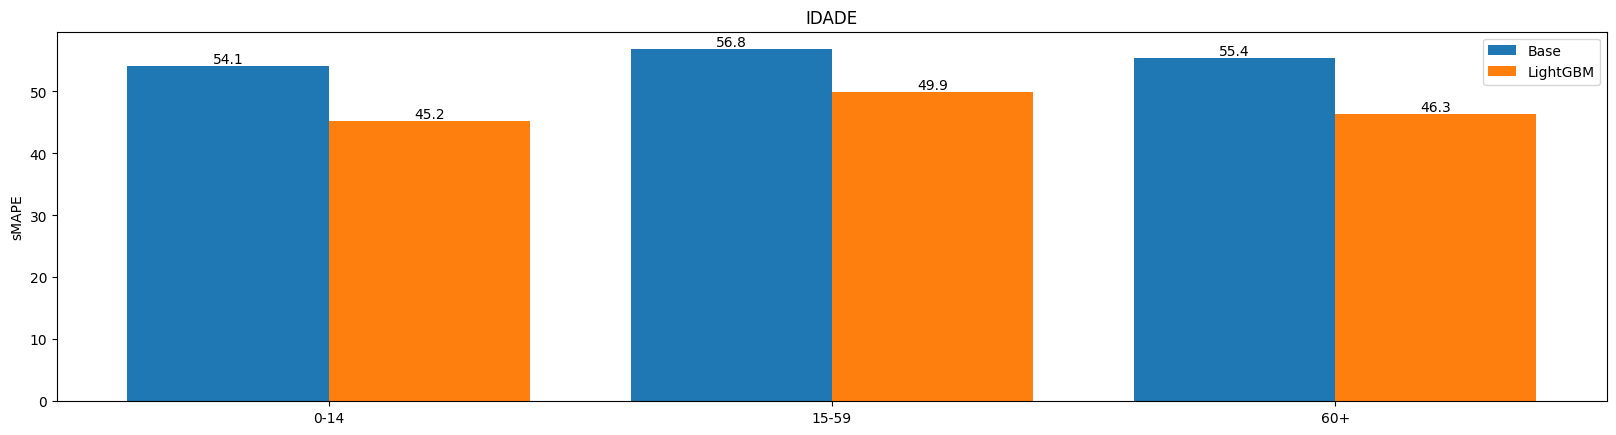

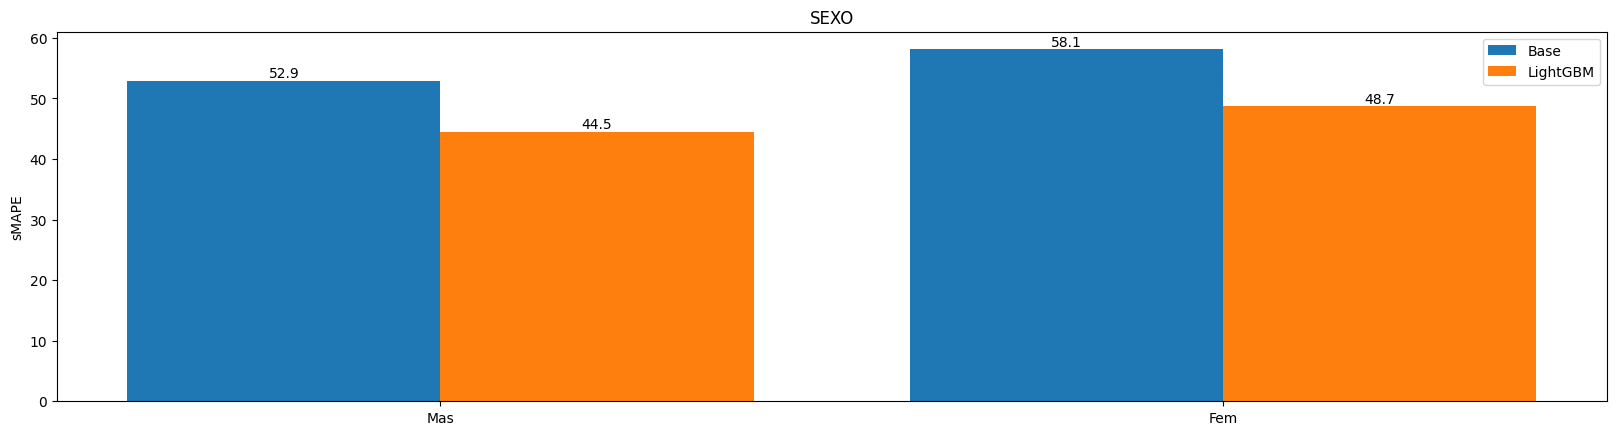

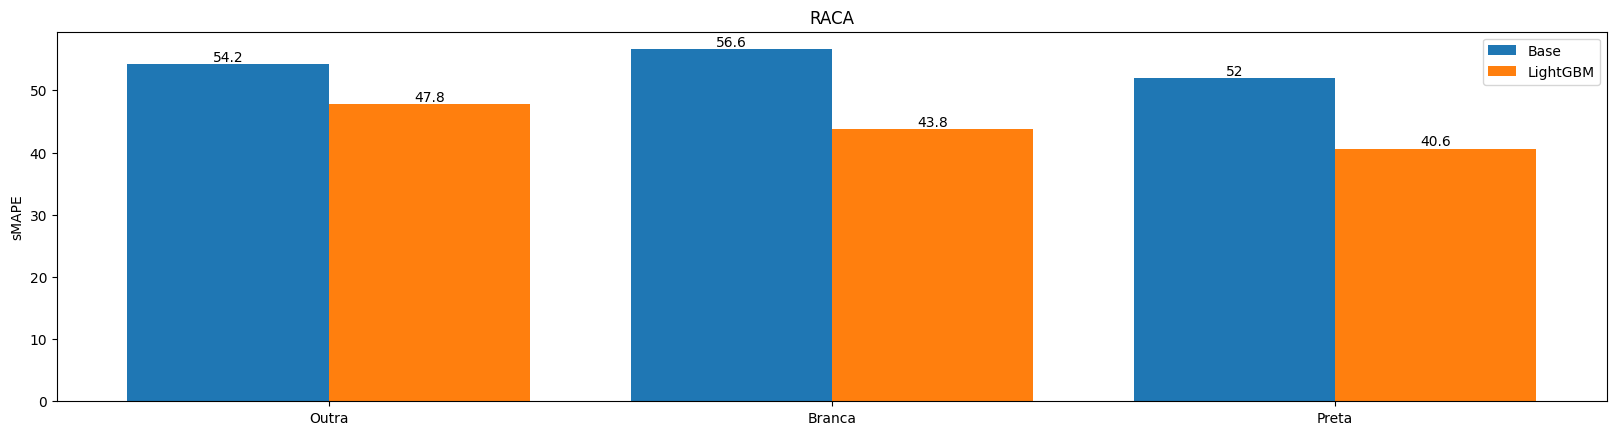

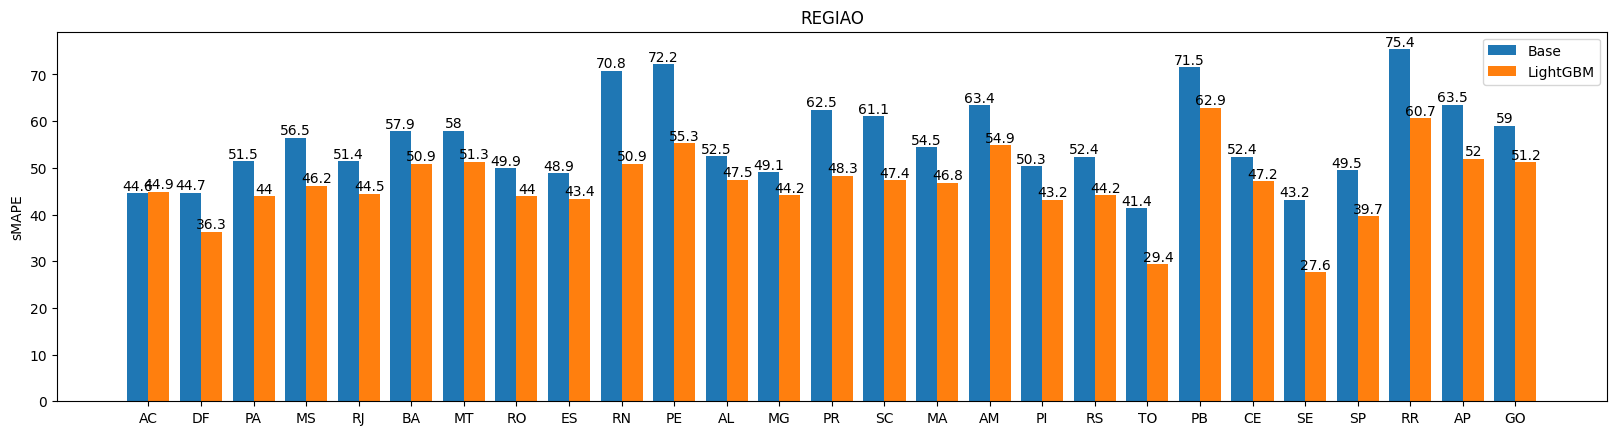

In [14]:
verificar_vies(df_resultados, "IDADE", "categoria_idade")
verificar_vies(df_resultados, "SEXO", "categoria_sexo")
verificar_vies(df_resultados, "RACA", "categoria_raca")
verificar_vies(df_resultados, "REGIAO", "region")

#### Segunda Análise 

Observa-se que o resultado da amostragem foi reduzir levemente os valores estaduais em geral. O pior caso desceu para 62% (PB) e o melhor desceu para 27% (SE). A diferença ainda é grande, mas a disparidade desceu de 39% para 35%, além de melhorar um pouco a performance do modelo.

O objetivo de algoritmos e metodologias para mitigação de viés é apenas esse, reduzir a diferença de performance entre diferentes grupos. Comumente, esses métodos levaram a uma pior performance geral do modelo, em troca de um modelo mais justo.

A reamostragem teve mínimo impacto no desempenho nas outras categorias. É possível que, em casos onde o impacto é perceptível, seja útil implementar reamostragem nos outros dados, ou experimentar outros métodos de mitigação de viés.